# Market basket analysis: IMDb Dataset

#### Casati Martina (942413)
#### Frattini Andrea (959213) 
#### Lo Vecchio Gianluca (961536)
##### DSE(2020-2021)

## Download the dataset through Kaggle API

In [1]:
!pip install kaggle

     |████████████████████████████████| 58 kB 3.9 MB/s  eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=50ce034bcac2675bf1d40d58aabdfa0de31f98b2d8b9f767a7089e7d2f4ac75c
  Stored in directory: /home/jupyter/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle


In [2]:
!mkdir ~/.kaggle

In [3]:
!cp ~/Download/kaggle.json ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d 'ashirwadsangwan/imdb-dataset'

 99%|██████████████████████████████████████▌| 1.42G/1.44G [00:04<00:00, 377MB/s]
100%|███████████████████████████████████████| 1.44G/1.44G [00:05<00:00, 308MB/s]


In [5]:
!unzip \*.zip && rm *.zip

Archive:  imdb-dataset.zip
  inflating: name.basics.tsv.gz      
  inflating: name.basics.tsv/name.basics.tsv  
  inflating: title.akas.tsv.gz       
  inflating: title.akas.tsv/title.akas.tsv  
  inflating: title.basics.tsv.gz     
  inflating: title.basics.tsv/title.basics.tsv  
  inflating: title.principals.tsv.gz  
  inflating: title.principals.tsv/title.principals.tsv  
  inflating: title.ratings.tsv.gz    
  inflating: title.ratings.tsv/title.ratings.tsv  


## Setting up the Jupyter Notebook environment for the VM of Google Cloud Platform

In [1]:
!pip install pyspark
import pyspark
from pyspark import SparkContext
sc = pyspark.SparkContext('local[*]')
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_set, col, count
spark = SparkSession.builder.appName("Market Basekt Analysis").getOrCreate()

import itertools

import pandas as pd

import time

import matplotlib.pyplot as plt

## Loading the datasets

First we import the tables of interest assigning to them intuitive labels. Secondly we show the first 10 rows of each one to understand how they are structured.

In [2]:
FilmTitle = spark.read.csv("title.basics.tsv", sep=r'\t', header=True)
Job = spark.read.csv("title.principals.tsv", sep=r'\t', header=True)
NamesCast = spark.read.csv("name.basics.tsv", sep=r'\t', header=True)

In [3]:
FilmTitle.show(10)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            \N|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

In [4]:
Job.show(10)

+---------+--------+---------+---------------+--------------------+-----------+
|   tconst|ordering|   nconst|       category|                 job| characters|
+---------+--------+---------+---------------+--------------------+-----------+
|tt0000001|       1|nm1588970|           self|                  \N|["Herself"]|
|tt0000001|       2|nm0005690|       director|                  \N|         \N|
|tt0000001|       3|nm0374658|cinematographer|director of photo...|         \N|
|tt0000002|       1|nm0721526|       director|                  \N|         \N|
|tt0000002|       2|nm1335271|       composer|                  \N|         \N|
|tt0000003|       1|nm0721526|       director|                  \N|         \N|
|tt0000003|       2|nm5442194|       producer|            producer|         \N|
|tt0000003|       3|nm1335271|       composer|                  \N|         \N|
|tt0000003|       4|nm5442200|         editor|                  \N|         \N|
|tt0000004|       1|nm0721526|       dir

In [5]:
NamesCast.show(10)

+---------+---------------+---------+---------+--------------------+--------------------+
|   nconst|    primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+---------------+---------+---------+--------------------+--------------------+
|nm0000001|   Fred Astaire|     1899|     1987|soundtrack,actor,...|tt0050419,tt00531...|
|nm0000002|  Lauren Bacall|     1924|     2014|  actress,soundtrack|tt0071877,tt01170...|
|nm0000003|Brigitte Bardot|     1934|       \N|actress,soundtrac...|tt0054452,tt00491...|
|nm0000004|   John Belushi|     1949|     1982|actor,writer,soun...|tt0077975,tt00725...|
|nm0000005| Ingmar Bergman|     1918|     2007|writer,director,a...|tt0069467,tt00509...|
|nm0000006| Ingrid Bergman|     1915|     1982|actress,soundtrac...|tt0038109,tt00368...|
|nm0000007|Humphrey Bogart|     1899|     1957|actor,soundtrack,...|tt0043265,tt00338...|
|nm0000008|  Marlon Brando|     1924|     2004|actor,soundtrack,...|tt0070849,tt00787...|
|nm0000009

## PreProcessing

First we set the Spark SQL environment 

In [3]:
FilmTitle.createOrReplaceTempView("FilmTitle")
Job.createOrReplaceTempView("Job")

Secondly, since we need to consider actors and actresses as items, we extrapolate them from the "Job" table

In [5]:
actors =  """ SELECT *
              FROM Job
              WHERE (category = 'actor') OR (category = 'actress')
"""
actors = spark.sql(actors)
actors.show(10)

+---------+--------+---------+--------+---+--------------------+
|   tconst|ordering|   nconst|category|job|          characters|
+---------+--------+---------+--------+---+--------------------+
|tt0000005|       1|nm0443482|   actor| \N|      ["Blacksmith"]|
|tt0000005|       2|nm0653042|   actor| \N|       ["Assistant"]|
|tt0000007|       1|nm0179163|   actor| \N|                  \N|
|tt0000007|       2|nm0183947|   actor| \N|                  \N|
|tt0000008|       1|nm0653028|   actor| \N|    ["Sneezing Man"]|
|tt0000009|       1|nm0063086| actress| \N|["Miss Geraldine ...|
|tt0000009|       2|nm0183823|   actor| \N|    ["Mr. Hamilton"]|
|tt0000009|       3|nm1309758|   actor| \N|["Chauncey Depew ...|
|tt0000011|       1|nm3692297|   actor| \N|        ["Acrobats"]|
|tt0000014|       1|nm0166380|   actor| \N|    ["The Gardener"]|
+---------+--------+---------+--------+---+--------------------+
only showing top 10 rows



And then we extrapolate the movies from the table "FilmTitle", since we need to use them as baskets

In [6]:
movies =  """ SELECT *
              FROM FilmTitle
              WHERE titleType = 'movie'
         """
movies = spark.sql(movies)
movies.show(10)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000009|    movie|          Miss Jerry|          Miss Jerry|      0|     1894|     \N|            45|             Romance|
|tt0000147|    movie|The Corbett-Fitzs...|The Corbett-Fitzs...|      0|     1897|     \N|            20|Documentary,News,...|
|tt0000335|    movie|Soldiers of the C...|Soldiers of the C...|      0|     1900|     \N|            \N|     Biography,Drama|
|tt0000502|    movie|            Bohemios|            Bohemios|      0|     1905|     \N|           100|                  \N|
|tt0000574|    movie|The Story of the ...|The Story of the ...|      0|     1906|     \N|            70|Biography,Crim

Finally, we create the baskets joining the "Job" and "FilmTitle" tables considering only the actors, actresses and movies. Then we group by the ID of actors and actresses (tconst) and we list the title of the films in which they played under the 'ncosnt' column.

In [4]:
B =  """  SELECT Job.tconst, Job.nconst
          FROM Job LEFT JOIN FilmTitle ON Job.tconst = FilmTitle.tconst
          WHERE (Job.category == 'actor' OR Job.category == 'actress') AND FilmTitle.titleType == 'movie'
"""
a = spark.sql(B)
baskets = a.groupBy('tconst').agg(collect_set('nconst').alias('nconst'))
baskets.createOrReplaceTempView('baskets')
baskets.show(5)

+---------+--------------------+
|   tconst|              nconst|
+---------+--------------------+
|tt0002591|[nm0029806, nm050...|
|tt0003689|[nm0910564, nm052...|
|tt0004272|[nm0368875, nm009...|
|tt0004336|[nm0268437, nm081...|
|tt0005209|[nm0593671, nm039...|
+---------+--------------------+
only showing top 5 rows



Here we create a Resilient Distributed Dataset

In [7]:
act_bask = baskets.select('nconst').rdd.flatMap(list)
print(act_bask.collect()[:3])

[['nm0029806', 'nm0509573'], ['nm0910564', 'nm0527801', 'nm0399988', 'nm0101071', 'nm0694718', 'nm0728289', 'nm0585503'], ['nm0368875', 'nm0092665', 'nm0492302', 'nm0445507', 'nm0776747', 'nm0383278', 'nm0192062', 'nm0285643', 'nm0793189']]


## The A-Priori Algorithm

We initialize a threshold value after which the pairs of actors and actresses are considered frequent using a fraction (0.03%) of the number of baskets 

In [8]:
count = act_bask.count()
threshold = count*0.0003
print(count, threshold)

393656 118.09679999999999


Exploiting the functions "map", "reduceByKey" and "filter" of Spark (https://spark.apache.org/docs/latest/rdd-programming-guide.html) we create the A-Priori algorithm: this function takes as input an RDD and a threshold (previously defined); in the following we describe in details the code:
- singleton: through .flatMap we create a list, subsequently .map maps the item creating a tuple with the ID of the actor/actress and a counter (number of film in which he/her partecipated), then .reduceByKey, using actor/actress as key, sum their values up and finally .filter check if the counter of the previuos tuple is greater or equal than the threshold.
- freq_act: with .map we extrapolate from 'singleton' only the ID of the frequent actors/actresses
- pairs_of_freq_act = using .toLocalIterator we find all the possible pairs within the frequent_act
- table_of_pairs: through .flatMap we create a list and we add to it each item in pairs_of_freq_act that is a subset of a basket, then with .reduceByKey we sum up the actors/actresses using them as keys and finally with .filter we filter out all the items that have the second component (item[1], i.e. the counter) greater than the threshold.

In [9]:
def apriori (rdd, threshold):
  
  singleton = rdd.flatMap(list).map(lambda item: (item , 1)).reduceByKey(lambda actor1, actor2: actor1+actor2).filter(lambda item: item[1] >= threshold ) 

  freq_act = singleton.map(lambda item : (item[0])) # all the pair of frequent items 

  pairs_of_freq_act = list(itertools.combinations(freq_act.toLocalIterator(),2)) # finding all the possible pairs
  
  table_of_pairs = rdd.flatMap(lambda x : [(tuple(item), 1) for item in pairs_of_freq_act if set(list(item)).issubset(set(x))]).cache() \
                  .reduceByKey(lambda actor1, actor2: actor1+actor2) \
                  .filter(lambda item: item[1] >= threshold)

  return (table_of_pairs)

We run the A-Priori algorithm on on the enitre dataset and then we put the results into a dataframe in order to show tham in a pretty way 

In [10]:
AprioriResults = apriori(act_bask, threshold)
result = spark.createDataFrame(AprioriResults).toDF("Pairs of actors and actresses", "Number of movies")
result.show()

+-----------------------------+----------------+
|Pairs of actors and actresses|Number of movies|
+-----------------------------+----------------+
|         {nm0623427, nm000...|             237|
|         {nm0006982, nm061...|             122|
|         {nm0006982, nm041...|             162|
|         {nm0046850, nm000...|             169|
|         {nm2082516, nm064...|             147|
|         {nm2373718, nm064...|             126|
+-----------------------------+----------------+



Now we calculate the time necessary for running the algorithm on the entire dataset

In [16]:
startTime = time.time()
apriori(act_bask, threshold)
APrioriTime = time.time()-startTime
print(time.time()-startTime)

31.198248863220215


## FP Growth Algorithm

Using the library of FPGrowth we launch it and we calculate the running time

In [11]:
from pyspark.ml.fpm import FPGrowth
startTime = time.time()
fp = FPGrowth(itemsCol = "nconst", minSupport = 0.0003)
startTime = time.time()
FPGrowth_model = fp.fit(baskets)
FPGrowthTime = time.time()- startTime
print(time.time()- startTime)

18.56655979156494


We display the 10 most frequent items

In [12]:
FPGrowth_model.freqItemsets.show(10)

+-----------+----+
|      items|freq|
+-----------+----+
|[nm1388202]| 153|
|[nm0430646]| 120|
|[nm0103977]| 798|
|[nm0006982]| 585|
|[nm0436922]| 152|
|[nm0408381]| 120|
|[nm0648803]| 565|
|[nm0405977]| 152|
|[nm0576495]| 120|
|[nm0579663]| 120|
+-----------+----+
only showing top 10 rows



In [13]:
FPGrowth_model= FPGrowth_model.freqItemsets
FPGrowth_model.createOrReplaceTempView("FPGrowth_model")

In [14]:
q = """ SELECT *
        FROM FPGrowth_model 
        WHERE size (items) >= 2
        ORDER BY freq DESC
        """
spark.sql(q).show(10)

+--------------------+----+
|               items|freq|
+--------------------+----+
|[nm0623427, nm000...| 237|
|[nm0046850, nm000...| 169|
|[nm0419653, nm000...| 162|
|[nm2082516, nm064...| 147|
|[nm2373718, nm064...| 126|
|[nm0619779, nm000...| 122|
+--------------------+----+



## Running time comparisons between different algorithms 

A-Priori vs FP Growth given the entire dataset and the same threshold (0.0003)

In [ ]:
df = pd.DataFrame({'Type of algorithm':['APrioriTime', 'FPGrowthTime'], 'Time':[APrioriTime,FPGrowthTime]})
barplot = df.plot.bar(x='Type of algorithm', y='Time', rot = 0, color= 'g')

A-Priori vs FP Growth given the entire dataset but different threshold values

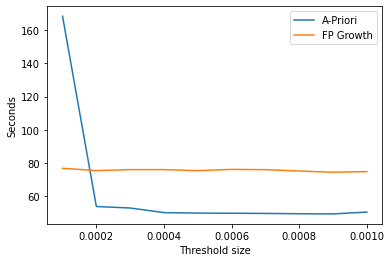

In [15]:
%matplotlib inline
x = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
y = [168.30824089050293,53.98464870452881,53.07268238067627,50.30917692184448,50.021188735961914,49.92609214782715,49.81086301803589,49.619282960891724,
     49.52366256713867,50.62602353096008]
plt.plot(x, y, label='A-Priori')

a = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
b = [76.92273926734924,75.54928350448608,76.14759802818298,76.14860796928406,75.51765608787537,76.26800203323364,76.12276768684387,75.29264044761658,
     74.58063530921936,74.95723581314087]
plt.plot(a, b, label='FP Growth')

plt.xlabel("Threshold size")
plt.ylabel("Seconds")

c = plt.legend()
plt.savefig('A-Priori vs FP.pdf')
plt.show()